In [2]:
import torch
from src.k_tree import Ktree
from src.k_tree_ls import Ktree as Ktree_ls
from src.utils.objects.squares import loadData as loadSquares
from src.metrics import Linf_simple
from src.utils import plot_tools as pt
from src.utils import accuracy as acc

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Creating 5000 line segments
x0 shape: torch.Size([5000])
l shape: torch.Size([5000])
theta shape: torch.Size([5000])
Data shape: torch.Size([5000, 4])
Data points shape: torch.Size([5000, 4])


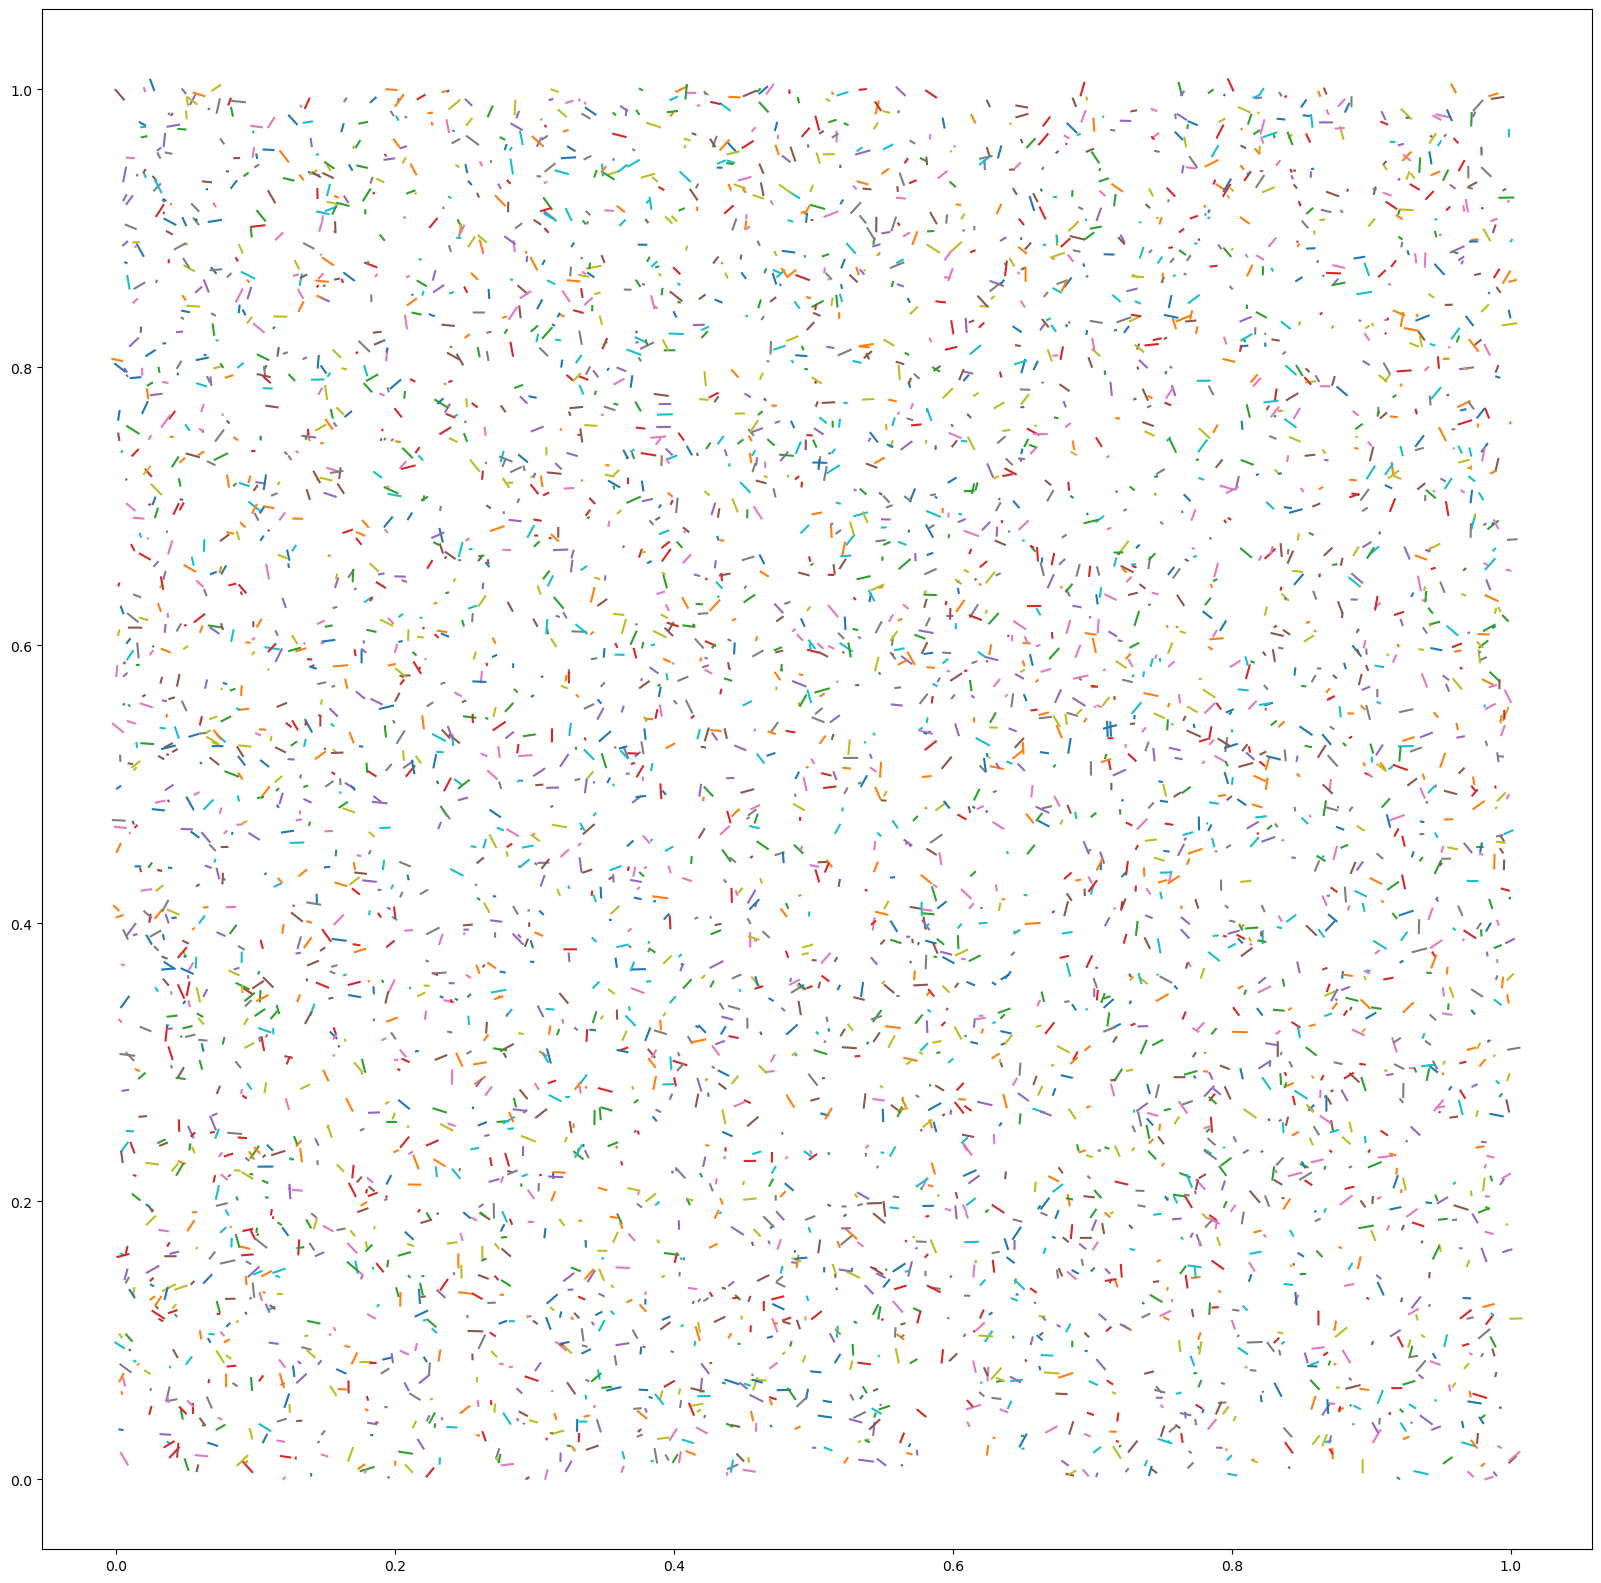

In [3]:
# lets generate #n line segments inside a bbox
n = 5000
bbox_lim = 1e5
var = 1000
var_ = 1
norm = bbox_lim
bbox_lim /= norm
var /= norm
var_ /= norm
bbox = [0, bbox_lim, 0, bbox_lim]  # bbox = [xmin,xmax,ymin,ymax
length_size = [var_, var]  # length of the line segment
theta_size = [0, 180]  # angle of the line segment
# normalize


# line segments will be [x0,y0,l,theta]
# sample x0,y0 inside bbox
def create_line_segments(n, bbox, length_size, theta_size):
    print(f"Creating {n} line segments")
    x0 = torch.rand(n) * (bbox[1] - bbox[0]) + bbox[0]
    y0 = torch.rand(n) * (bbox[3] - bbox[2]) + bbox[2]
    print(f"x0 shape: {x0.shape}")
    # sample l inside length_size
    l = torch.rand(n) * (length_size[1] - length_size[0]) + length_size[0]
    print(f"l shape: {l.shape}")
    # sample theta inside theta_size
    theta_size = torch.rand(n) * (theta_size[1] - theta_size[0]) + theta_size[0]
    print(f"theta shape: {theta_size.shape}")
    theta_size = torch.deg2rad(theta_size)
    return torch.stack([x0, y0, l, theta_size], dim=1)


data = create_line_segments(n, bbox, length_size, theta_size)
print(f"Data shape: {data.shape}")
# first make data from embedding to datapoints
data_points = torch.zeros(n, 4)
data_points[:, 0] = data[:, 0]
data_points[:, 1] = data[:, 1]
data_points[:, 2] = data[:, 0] + data[:, 2] * torch.cos(data[:, 3])
data_points[:, 3] = data[:, 1] + data[:, 2] * torch.sin(data[:, 3])
print(f"Data points shape: {data_points.shape}")
data2d = data

import matplotlib.pyplot as plt

# make plot size big
plt.figure(figsize=(20, 20))
plt.plot([data_points[:, 0], data_points[:, 2]], [data_points[:, 1], data_points[:, 3]])
plt.axis("equal")
plt.show()

In [6]:
import torch
from src.k_tree import Ktree
from src.k_tree_ls import Ktree as Ktree_ls
from src.utils.objects.squares import loadData as loadSquares
from src.metrics import Linf_simple
from src.utils import plot_tools as pt
from src.utils import accuracy as acc

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
# lets generate #n line segments inside a bbox
# n = 100
# bbox = [0, 1000, 0, 1000]  # bbox
# length_size = [0.1, 100]  # length of the line segment
# theta_size = [0, 180]  # angle of the line segment


# # line segments will be [x0,y0,l,theta]
# # sample x0,y0 inside bbox
# def create_line_segments(n, bbox, length_size, theta_size):
#     print(f"Creating {n} line segments")
#     x0 = torch.rand(n) * (bbox[1] - bbox[0]) + bbox[0]
#     y0 = torch.rand(n) * (bbox[3] - bbox[2]) + bbox[2]
#     print(f"x0 shape: {x0.shape}")
#     # sample l inside length_size
#     l = torch.rand(n) * (length_size[1] - length_size[0]) + length_size[0]
#     print(f"l shape: {l.shape}")
#     # sample theta inside theta_size
#     theta_size = torch.rand(n) * (theta_size[1] - theta_size[0]) + theta_size[0]
#     print(f"theta shape: {theta_size.shape}")
#     theta_size = torch.deg2rad(theta_size)
#     return torch.stack([x0, y0, l, theta_size], dim=1)


# data = create_line_segments(n, bbox, length_size, theta_size)
# print(f"Data shape: {data.shape}")
# # first make data from embedding to datapoints
# data_points = torch.zeros(n, 4)
# data_points[:, 0] = data[:, 0]
# data_points[:, 1] = data[:, 1]
# data_points[:, 2] = data[:, 0] + data[:, 2] * torch.cos(data[:, 3])
# data_points[:, 3] = data[:, 1] + data[:, 2] * torch.sin(data[:, 3])
# print(f"Data points shape: {data_points.shape}")
# data2d = data

dim = 2  # space dimension

k = 3  # number of centroids to generate in the Clustering model
clustering_args = {
    "epochs": 10,  # number of epochs
    "pre_processing": 10,
    "number_of_centroids": k,  # number of centroids to generate in the Clustering model
    "dimension": dim,  # space dimension
}
n = 30
un_args = {
    "N": n,  # number of points to sample
    "M": n**2 - 1,  # number of points to return
    "epsilon": 0.15,  # the epsilon ball
}
critic_args = {
    "optimizer_lr": 5e-3,  # optimiser learning rate
    "epochs": 2000,  # number of epochs
    "width": 300,  # width of the model's linear layers
    "depth": 5,  # depth of the model's linear layers
}

threshold = 100 * k  # if a tree node has data less than the threshold, stop division

# Initialise the k-tree structure.
from src.metrics import compute_distances_2d

# pass data to the k-tree
distance_function = compute_distances_2d
ktree = Ktree_ls(
    threshold,
    data2d,
    distance_function,
    clustering_args,
    un_args,
    critic_args,
    device,
    dim,
)
# pass data to device
data = data.to(device)
print("Starting to create the tree...")
print("=" * 20)
ktree.create_tree(save_path_prefix="./models/line_segments/2d/5k/", plot=False)

Starting to create the tree...

Creating critic for node 0 that has 5000 data, which is more than the threshold 300.
Bounding box for node 0: tensor([[-0.0069,  1.0089],
        [-0.0059,  1.0081]], device='cuda:0')
Creating clustering for node 0 with 3 centroids.
Initial divergence: 1349.397216796875
Iteration 1, divergence: 1349.397216796875
Iteration 2, divergence: 1197.94384765625
Iteration 3, divergence: 1178.59375
Iteration 4, divergence: 1175.7127685546875
Iteration 5, divergence: 1175.35888671875
Iteration 6, divergence: 1175.30517578125
Iteration 7, divergence: 1175.23974609375
Iteration 8, divergence: 1175.203125
Iteration 9, divergence: 1175.1385498046875
Iteration 10, divergence: 1175.0875244140625
getUncertaintyArea
Centroids are [[0.7768425  0.33350495]
 [0.49415705 0.8072684 ]
 [0.22684634 0.3165337 ]]
scale is 1.0158805847167969
Processing...
flag is 635
m is 266
i is 900
Labeled 0/266 points.


KeyboardInterrupt: 

In [ ]:
import numpy as np

# np.random.seed(0)
n = 100
random_points = torch.zeros(n, ktree.dim)
space = ktree.root.get_bounding_box().to("cpu")  # get the bounding box of the tree
for i in range(n):
    random_points[i] = torch.tensor(
        # [np.random.uniform(space[d][0], space[d][1]) for d in range(ktree.dim)]
        [
            torch.rand(1) * (space[d][1] - space[d][0]) + space[d][0]
            for d in range(ktree.dim)
        ]
    )
# pass points on device
# make them torch
random_points = random_points.to(device)
st_acc = ktree.get_critic_accuracies(random_points)

print(st_acc)

In [ ]:
acc.random_queries(ktree, n=100, times=3, k=2)
# acc.serialised_queries(ktree, n=10, k=3)